# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files 

In [0]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      
    

In [0]:
batch_size = 32

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

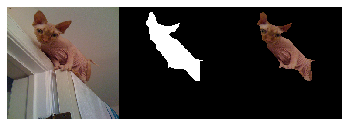

In [0]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [0]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [0]:
# Custom Loss Function

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

# Model

In [0]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #Contracting layers
  nKernels = 8
  layers = []

  # level_1 (256, 256, 3)
  layer11 = Conv2D(nKernels, 3, activation='relu', padding='same', kernel_initializer='he_normal') (x)
  layer11 = BatchNormalization() (layer11)
  layer12 = Conv2D(nKernels, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer11)
  layer12 = BatchNormalization() (layer12)
  layers.append(layer12)
  layer13 = MaxPooling2D() (layer12)
  
  # level_2 (128, 128, 8)
  layer21 = Conv2D(nKernels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer13)
  layer21 = BatchNormalization() (layer21)
  layer22 = Conv2D(nKernels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer21)
  layer22 = BatchNormalization() (layer22)
  layers.append(layer22)
  layer23 = MaxPooling2D() (layer22)

  # level_3 (64, 64, 16)
  layer31 = Conv2D(nKernels*4, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer23)
  layer31 = BatchNormalization() (layer31)
  layer32 = Conv2D(nKernels*4, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer31)
  layer32 = BatchNormalization() (layer32)
  layers.append(layer32)
  layer33 = MaxPooling2D() (layer32)

  # level_4 (32, 32, 32)
  layer41 = Conv2D(nKernels*8, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer33)
  layer41 = BatchNormalization() (layer41)
  layer42 = Conv2D(nKernels*8, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer41)
  layer42 = BatchNormalization() (layer42)
  layers.append(layer42)
  layer43 = MaxPooling2D() (layer42)

  # level_5 (16, 16, 64)
  layer51 = Conv2D(nKernels*16, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer43)
  layer51 = BatchNormalization() (layer51)
  layer52 = Conv2D(nKernels*16, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer51)
  layer52 = BatchNormalization() (layer52)
  layers.append(layer52)
  layer53 = MaxPooling2D() (layer52)

  # level_6 (8, 8, 128)
  layer61 = Conv2D(nKernels*32, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer53)
  layer61 = BatchNormalization() (layer61)
  layer62 = Conv2D(nKernels*32, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer61)
  layer62 = BatchNormalization() (layer62)
  layers.append(layer62)
  layer63 = MaxPooling2D() (layer62)
  
  # BottleNeck (4, 4, 256)
  bottleneck11 = Conv2D(nKernels*64, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer63)
  bottleneck11 = BatchNormalization() (bottleneck11)
  bottleneck12 = Conv2D(nKernels*64, 3, activation='relu', padding='same', kernel_initializer='he_normal') (bottleneck11)
  bottleneck12 = BatchNormalization() (bottleneck12)
  bottleneck13 = Conv2DTranspose(nKernels*32, 2, strides=(2, 2), padding='same') (bottleneck12)
  level = len(layers) - 1
  layer71 = Concatenate(axis=3)([bottleneck13, layers[level]])
  
  # level 7 = level 6
  layer72 = Conv2D(nKernels*32, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer71)
  layer72 = BatchNormalization() (layer72)
  layer73 = Conv2D(nKernels*32, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer72)
  layer73 = BatchNormalization() (layer73)
  layer74 = Conv2DTranspose(nKernels*16, 2, strides=(2, 2), padding='same') (layer73)
  level = len(layers) - 2
  layer81 = Concatenate(axis=3)([layer74, layers[level]])
  
  # level 8 = level 5
  layer82 = Conv2D(nKernels*16, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer81)
  layer82 = BatchNormalization() (layer82)
  layer83 = Conv2D(nKernels*16, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer82)
  layer83 = BatchNormalization() (layer83)
  layer84 = Conv2DTranspose(nKernels*8, 2, strides=(2, 2), padding='same') (layer83)
  level = len(layers) - 3
  layer91 = Concatenate(axis=3)([layer84, layers[level]])

  # level 9 = level 4
  layer92 = Conv2D(nKernels*8, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer91)
  layer92 = BatchNormalization() (layer92)
  layer93 = Conv2D(nKernels*8, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer92)
  layer93 = BatchNormalization() (layer93)
  layer94 = Conv2DTranspose(nKernels*4, 2, strides=(2, 2), padding='same') (layer93)
  level = len(layers) - 4
  layer101 = Concatenate(axis=3)([layer94, layers[level]])

  # level 10 = level 3
  layer102 = Conv2D(nKernels*4, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer101)
  layer102 = BatchNormalization() (layer102)
  layer103 = Conv2D(nKernels*4, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer102)
  layer103 = BatchNormalization() (layer103)
  layer104 = Conv2DTranspose(nKernels*2, 2, strides=(2, 2), padding='same') (layer103)
  level = len(layers) - 5
  layer111 = Concatenate(axis=3)([layer104, layers[level]])
  
  # level 11 = level 2
  layer112 = Conv2D(nKernels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer111)
  layer112 = BatchNormalization() (layer112)
  layer113 = Conv2D(nKernels*2, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer112)
  layer113 = BatchNormalization() (layer113)
  layer114 = Conv2DTranspose(nKernels, 2, strides=(2, 2), padding='same') (layer113)
  level = len(layers) - 6
  layer121 = Concatenate(axis=3)([layer114, layers[level]])
      
  #level 1 = classification 
  classification1 = Conv2D(nKernels, 3, activation='relu', padding='same', kernel_initializer='he_normal') (layer121)
  classification1 = BatchNormalization() (classification1)
  classification1 = Dropout(0.5) (classification1)
  classification2 = Conv2D(nKernels, 3, activation='relu', padding='same', kernel_initializer='he_normal') (classification1)
  classification2 = BatchNormalization() (classification2)
  classification2 = Dropout(0.5) (classification2)
  outputs = Conv2D(1, 1, activation='sigmoid') (classification2)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = weighted_bce_dice_loss, metrics = [mean_iou])
  
  return model

In [0]:
model = unet()

# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

i= 1 loss= 1.0759296330142782 val_loss= 1.0697441155260259 mean_iou= 0.4668796646948819 val_mean_iou= 0.6115113984454762


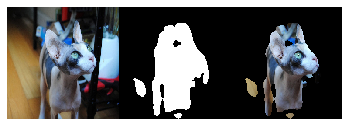

i= 2 loss= 0.7579310041040046 val_loss= 0.8683394952253862 mean_iou= 0.6575154814545967 val_mean_iou= 0.6721676100384105


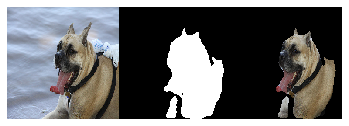

i= 3 loss= 0.6555909065351094 val_loss= 0.5818580930883234 mean_iou= 0.7149539132640786 val_mean_iou= 0.71970749985088


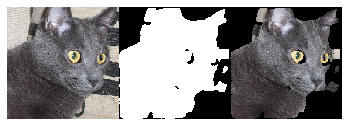

i= 4 loss= 0.6005204720039891 val_loss= 0.6008811755613848 mean_iou= 0.7456016399000334 val_mean_iou= 0.7248201803727583


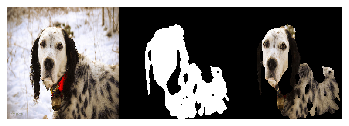

i= 5 loss= 0.5609791866720539 val_loss= 0.5008332566781477 mean_iou= 0.7657548121121376 val_mean_iou= 0.7743227590214122


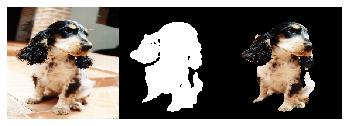

i= 6 loss= 0.5243408523465944 val_loss= 0.5106393261389299 mean_iou= 0.7849369522643416 val_mean_iou= 0.7724829532883384


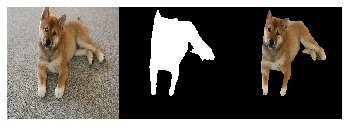

i= 7 loss= 0.5001038063878882 val_loss= 0.5105994668873873 mean_iou= 0.7979546788076287 val_mean_iou= 0.7572702331976457


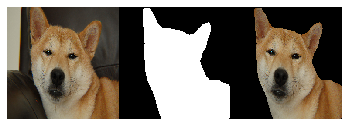

i= 8 loss= 0.4739248428714874 val_loss= 0.4539134746248072 mean_iou= 0.8109986387431349 val_mean_iou= 0.8067633021961559


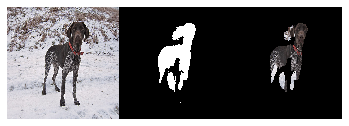

i= 9 loss= 0.4493033868264934 val_loss= 0.45264589244669134 mean_iou= 0.8238440871783043 val_mean_iou= 0.7981656302105297


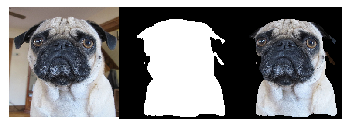

i= 10 loss= 0.43312464606816364 val_loss= 0.44984617829322815 mean_iou= 0.8300698266181772 val_mean_iou= 0.795850011435422


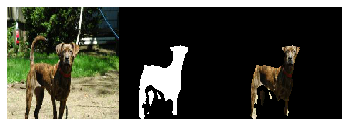

i= 11 loss= 0.41697695034824006 val_loss= 0.5130750428546559 mean_iou= 0.8392153877645867 val_mean_iou= 0.8013370470567183


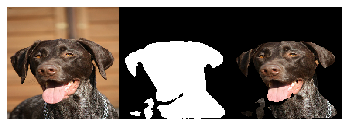

i= 12 loss= 0.39867329515822947 val_loss= 0.45625080303712323 mean_iou= 0.8509670485100246 val_mean_iou= 0.809222400188446


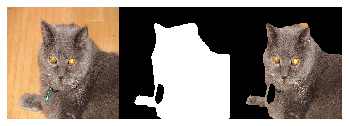

i= 13 loss= 0.38905498603163247 val_loss= 0.4575187482617118 mean_iou= 0.8538377584387723 val_mean_iou= 0.8184532956643538


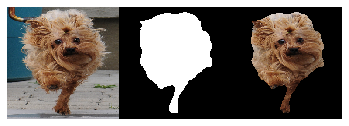

i= 14 loss= 0.37525269021726637 val_loss= 0.5108493214303796 mean_iou= 0.8608202392652154 val_mean_iou= 0.7955381274223328


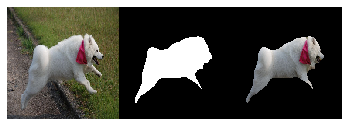

i= 15 loss= 0.3655087032002401 val_loss= 0.5035544281656091 mean_iou= 0.8652410763039436 val_mean_iou= 0.7989360690116882


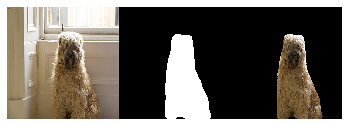

i= 16 loss= 0.3530803397638068 val_loss= 0.44338167255575006 mean_iou= 0.8712655654236606 val_mean_iou= 0.8198624415831133


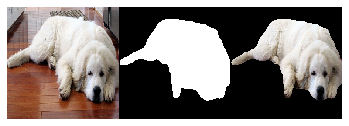

i= 17 loss= 0.3448952073103761 val_loss= 0.44007378816604614 mean_iou= 0.8754502660063304 val_mean_iou= 0.8233076767487959


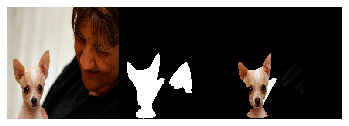

i= 18 loss= 0.336148932372054 val_loss= 0.4369631734761325 mean_iou= 0.8774832195887282 val_mean_iou= 0.8159307729114186


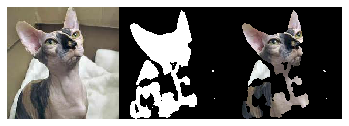

i= 19 loss= 0.32210699499469914 val_loss= 0.47987800294702704 mean_iou= 0.885094923243675 val_mean_iou= 0.8179858110167764


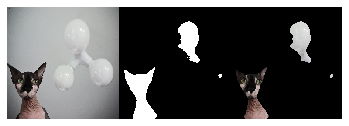

i= 20 loss= 0.3172457023570527 val_loss= 0.4821047999642112 mean_iou= 0.8855033887031416 val_mean_iou= 0.8177684437144886


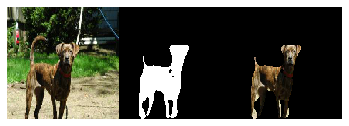

i= 21 loss= 0.3077677206633842 val_loss= 0.5023793280124664 mean_iou= 0.8908830921943873 val_mean_iou= 0.8290913917801597


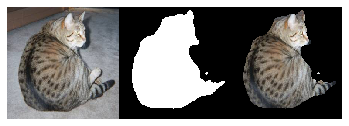

i= 22 loss= 0.3017490130581268 val_loss= 0.4512232704596086 mean_iou= 0.893142077748634 val_mean_iou= 0.8302980173717845


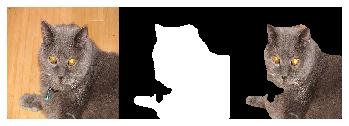

i= 23 loss= 0.29260557372820434 val_loss= 0.46784007820216095 mean_iou= 0.8965465731272414 val_mean_iou= 0.8273653008721091


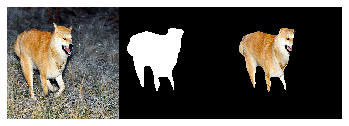

i= 24 loss= 0.2853468625921093 val_loss= 0.5186195807023481 mean_iou= 0.8990950951837513 val_mean_iou= 0.8208442059430209


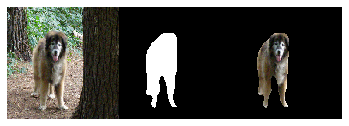

i= 25 loss= 0.27896765282709307 val_loss= 0.5379758964885365 mean_iou= 0.901450105453735 val_mean_iou= 0.8089460351250388


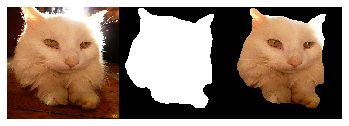

i= 26 loss= 0.27418477738012464 val_loss= 0.48727909272367304 mean_iou= 0.903974259280723 val_mean_iou= 0.8345884789120067


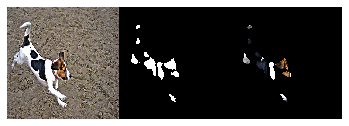

i= 27 loss= 0.26648085350043155 val_loss= 0.47762482274662366 mean_iou= 0.9072365472305856 val_mean_iou= 0.8256234201517972


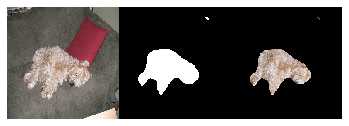

i= 28 loss= 0.2647982943275748 val_loss= 0.5546628453514793 mean_iou= 0.9071815732407243 val_mean_iou= 0.8169785250316967


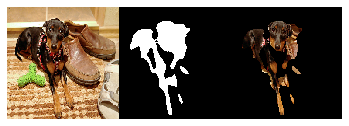

i= 29 loss= 0.25678406519704755 val_loss= 0.4808376892046495 mean_iou= 0.9103594324360155 val_mean_iou= 0.8396970521319996


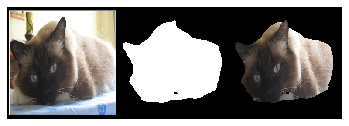

i= 30 loss= 0.2515190260051048 val_loss= 0.4763463789766485 mean_iou= 0.9123616752014857 val_mean_iou= 0.8312620303847573


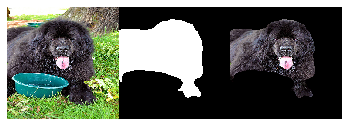

In [0]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [0]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2020-03-05 12:32:56--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.224.12.41, 13.224.12.16, 13.224.12.69, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.224.12.41|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.01s   

2020-03-05 12:32:56 (5.53 MB/s) - ‘test.jpg’ saved [63219/63219]



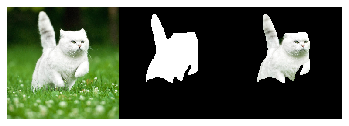

In [0]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

